In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [35]:
dirname = "C://Users//ruiya//Desktop//projet_ecl"
DATA_FILE = os.path.join(dirname,'generative_data//data.txt')
ENCODER_FILE1 = os.path.join(dirname,'no_stem_checkpoints//encoder20000_para.pkl') #no use stemming
ENCODER_FILE2 = os.path.join(dirname,'new_checkpoints//encoder_35000_stem_ns_para.pkl') #use stemming
DECODER_FILE1 = os.path.join(dirname,'no_stem_checkpoints//decoder20000_para.pkl') # no use stemming
DECODER_FILE2 = os.path.join(dirname,'new_checkpoints//decoder_35000_stem_ns_para.pkl') #use stemming

Loading data files
==================

The data for this project is a set of questions/anwers pairs.


We will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
hundred words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"Null" :2}
        self.word2count = {}#count the frenquence of a word appear in the document
        self.index2word = {0: "SOS", 1: "EOS", 2:"Null"} # SOS : start of sentence; EOS: end of sentence; 
        # Null : word doesn't exist in the traning data.
        self.n_words = 3  # Count SOS and EOS and Null

    def addSentence(self, sentence):
        ''' add  a sentence to the class'''
        for word in sentence.split():
            if word == '':
                print('****************',sentence)
            self.addWord(word)
         
    def addWord(self, word):
        ''' add a word to the class '''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.


In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters except digits
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"(['\'()/&!{}\-\’])", r" ", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    #s = re.sub(r"[^a-zA-Z0-9?]+", r" ", s)
    #s = re.sub(r"[^a-zA-Z0-9?&\'\’\%\-]+", r" ", s)
    #s = re.sub(r"[^a-zA-Z0-9?&\%\-]+", r" ", s)
    return s


To read the data file we will split the file into lines, and then split
lines into pairs. If we want to infer the question from the answers, the ``reverse``
flag is added to reverse the pairs.


In [6]:
def readLangs(questions, answers, reverse=False,stem=False):
    print("Reading lines...")
        
    lines = open(DATA_FILE, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')] for l in lines]
    if stem:
        for pair in pairs:
            pair[0] = stemString(pair[0],stemmer)
            pair[0] = normalizeString(pair[0])
            pair[1] = normalizeString(pair[1])
    else : 
        for pair in pairs:
            pair[0] = normalizeString(pair[0])
            pair[1] = normalizeString(pair[1])
            
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(answers)
        output_lang = Lang(questions)
    else:
        input_lang = Lang(questions)
        output_lang = Lang(answers)

    return input_lang, output_lang, pairs

In [48]:
MAX_LENGTH = 25
# we use stopwords to delete those words not meaningfull
stopwords = 'de du des d le la les l ce c ci ça m me ma si t sur n en s si a y au un une on il nous vous je j a b c d e r f avoir'.split()

#stopwords = []

def TrimWordsSentence(sentence):
    resultwords = [word for word in sentence.split() if word.lower() not in stopwords]
    resultwords = ' '.join(resultwords)
    return resultwords

def TrimWords(pairs):
    for pair in pairs: 
        pair[0] = TrimWordsSentence(pair[0])
        pair[1] = TrimWordsSentence(pair[1])
    return pairs

# delete longer sentences
def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
        len(p[1].split()) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
s=" L'adresse (e-mail du) Responsable /Prospection /du {J.E.} est julien.gaubil@ecl19.ec-lyon.fr é"
print(s)
s = normalizeString(s)
print(s)
s = TrimWordsSentence(s)
print(s)

 L'adresse (e-mail du) Responsable /Prospection /du {J.E.} est julien.gaubil@ecl19.ec-lyon.fr é
l adresse  e mail du  responsable  prospection  du  j.e.  est julien.gaubil@ecl19.ec lyon.fr e
adresse mail responsable prospection j.e. est julien.gaubil@ecl19.ec lyon.fr


The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs

In [9]:
def prepareData(lang1, lang2, reverse=False,stem=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse,stem)
    print("Read %s sentence pairs" % len(pairs))
    pairs = TrimWords(pairs)
    
    for pair in [pair for pair in pairs if not filterPair(pair)]:
        print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
    
    pairs = filterPairs(pairs)
    
    print('')
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        if '' in output_lang.word2index: print(pair[1].split())
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [10]:
input_lang, output_lang, pairs = prepareData('questions', 'answers', False)

Reading lines...
Read 5554 sentence pairs
quelles actions formations contient ue mathematiques ? (7) -> ue mathematiques contient actions formation mth tc 1 : analyse appliquee, mth tc 2 : analyse numerique, mth tc 3 : probabilites statistique, mth tc 4 : mathematiques adaptees i algebr (31)
quelles actions formations contient ue informatique ? (7) -> ue informatique contient actions formation inf tc1 : algorithmique et structures donnees : conception, analyse et implementation, inf tc2 : conception et programmation objet, et inf tc3 (27)
quelles actions formations contient ue energie electrique et commande systemes ? (11) -> ue energie electrique et commande systemes contient actions formation ecs tc 0 : autonomie, ecs tc 1 : cours energie electrique, ecs tc 2 : cours d‘automatique procedes line (29)
quelles actions formations contient ue sciences et techniques information ? (10) -> ue sciences et techniques information contient actions formation sti tc 0 : autonomie sti, sti tc 1 : s

qu apprend dans cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
quel est descriptif cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
que voit dans matiere mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend dans matiere mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
fait quoi mth tc 2 : analyse numerique ? (9) -> description af mth tc 

apprend quoi dans cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend dans cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
quel est descriptif cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
que voit dans matiere mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend dans matiere mth tc 2 : analyse numerique ? (11) -> descrip

qu apprend dans ue mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
apprend quoi dans cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend dans cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
quel est descriptif cours mth tc 2 : analyse numerique ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
que voit dans matiere mth tc 2 : analyse numerique ? (11) -> description 

qu apprend dans matiere mth tc 4 : mathematiques adaptees i algebre analyse ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
fait quoi mth tc 4 : mathematiques adaptees i algebre analyse ? (12) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend mth tc 4 : mathematiques adaptees i algebre analyse ? (12) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
que voit dans afmth tc 4 : mathematiques adaptees i algebre analyse ? (13) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)

apprend quoi dans cours mth tc 4 : mathematiques adaptees i algebre analyse ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend dans cours mth tc 4 : mathematiques adaptees i algebre analyse ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
quel est descriptif cours mth tc 4 : mathematiques adaptees i algebre analyse ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
que voit dans matiere mth tc 4 : mathematiques adaptees i algebre analyse ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathem

qu apprend inf tc3 : projet application web ? (9) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
que voit dans afinf tc3 : projet application web ? (10) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dans ue inf tc3 : projet application web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
apprend quoi dans cours inf tc3 : projet application web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dans cours inf tc3 : projet application web ? (11) -> description af inf

fait quoi inf tc3 : projet application web ? (9) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend inf tc3 : projet application web ? (9) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
que voit dans afinf tc3 : projet application web ? (10) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dans ue inf tc3 : projet application web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
apprend quoi dans cours inf tc3 : projet application web ? (11) -> description af inf tc3 : projet

qu apprend dans matiere inf tc3 : projet application web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
fait quoi ecs tc 2 : cours d‘automatique procedes lineaires ? (11) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend ecs tc 2 : cours d‘automatique procedes lineaires ? (11) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
que voit dans afecs tc 2 : cours d‘automatique procedes lineaires ? (12) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dans ue ecs tc 2 : cours d‘automatique procedes

qu apprend dans cours ecs tc 2 : cours d‘automatique procedes lineaires ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
quel est descriptif cours ecs tc 2 : cours d‘automatique procedes lineaires ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
que voit dans matiere ecs tc 2 : cours d‘automatique procedes lineaires ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dans matiere ecs tc 2 : cours d‘automatique procedes lineaires ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
fait quoi ecs 

que voit dans afecs tc 2 : cours d‘automatique procedes lineaires ? (12) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dans ue ecs tc 2 : cours d‘automatique procedes lineaires ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
apprend quoi dans cours ecs tc 2 : cours d‘automatique procedes lineaires ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dans cours ecs tc 2 : cours d‘automatique procedes lineaires ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
quel est descriptif cours e

que voit dans matiere travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dans matiere travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
fait quoi travaux pratiques science et genie materiaux et surfaces ? (11) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend travaux pratiques science et genie materiaux et surfaces ? (11) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprie

que voit dans aftravaux pratiques science et genie materiaux et surfaces ? (12) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dans ue travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
apprend quoi dans cours travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dans cours travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acced

quel est descriptif cours travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
que voit dans matiere travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dans matiere travaux pratiques science et genie materiaux et surfaces ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
fait quoi travailler aujourd hui ? (6) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci 

qu apprend dans cours travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
quel est descriptif cours travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
que voit dans matiere travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dans matiere travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
fait quoi travailler aujourd hui ? (6) -> description af travailler au

apprend quoi dans cours travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dans cours travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
quel est descriptif cours travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
que voit dans matiere travailler aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dans matiere travailler aujourd hui ? (8) -> description af

Questions and answers pairs

In [11]:
for i in range(10):
    pair = pairs[i]
    print(pair)

['qui est trez vp compta bar ?', 'daval_tsuna_emile est trez vp compta bar']
['quel est numero telephone trez vp compta bar ?', 'numero telephone trez vp compta bar est 0619976495']
['quel est adresse mail trez vp compta bar ?', 'adresse mail trez vp compta bar est emile.daval@ecl19.ec lyon.fr']
['qui est trez vp foyer bar ?', 'roszak_axo_mathieu est trez vp foyer bar']
['quel est numero telephone trez vp foyer bar ?', 'numero telephone trez vp foyer bar est 0787824054']
['quel est adresse mail trez vp foyer bar ?', 'adresse mail trez vp foyer bar est mathieu.roszak@laposte.net']
['qui est vp hh bar ?', 'berre_eren_antonin est vp hh bar']
['quel est numero telephone vp hh bar ?', 'numero telephone vp hh bar est 0652317273']
['quel est adresse mail vp hh bar ?', 'adresse mail vp hh bar est antonin.le berre@ecl19.ec lyon.fr']
['qui est vp hh bar ?', 'masfrand_luchot_aldric est vp hh bar']


In [12]:
print("length of input word dict: {}\n".format(len(input_lang.index2word)))
print("length of output word dict : {}\n".format(len(output_lang.index2word)))

length of input word dict: 976

length of output word dict : 2666



The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for dialogue systems.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.

The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.


In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result

# Attention Decoder


If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))#, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))#, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result

Note: There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`

# Training


Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.

In [15]:
def indexesFromSentence(lang, sentence,MAX_LENGTH=25):
    words = sentence.split()
    if len(words)>MAX_LENGTH:
        new_words = random.choices(words,k=MAX_LENGTH)
    else:
        new_words = words
    
    
    a = []
    for word in new_words:
        try:
            a.append(lang.word2index[word])
        except KeyError:
            a.append(lang.word2index['Null'])
    
    return a

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    return result

def variablesFromPair(input_lang,output_lang,pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [16]:

print(indexesFromSentence(input_lang,"je suis",MAX_LENGTH))
print(input_lang.index2word[2])#beacuse "je" is in the stopwords, so it correspond "NULL"
print(input_lang.index2word[343])


[2, 336]
Null
ai


In [17]:
variableFromSentence(input_lang, "je suis")
# token "1" : <EOS> END OF SENTENCE

tensor([[  2],
        [336],
        [  1]])

In [18]:
print(variablesFromPair(input_lang,output_lang,pairs[0]))
# there are two tensors one for question another for answer.

(tensor([[3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9],
        [1]]), tensor([[3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [1]]))


Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct answer -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the answer
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.



In [19]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            #decoder_output, decoder_hidden = decoder(
             #   decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            #decoder_output, decoder_hidden = decoder(
             #   decoder_input, decoder_hidden)       
            
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0].item()

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    #return loss.data[0] / target_length
    return loss.item() / target_length

In [20]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [21]:
def trainIters(encoder, decoder,input_lang,output_lang,new_pairs, n_iters,save_name="", print_every=1000, plot_every=100, learning_rate=0.01,criterion = nn.NLLLoss()):
   
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [variablesFromPair(input_lang,output_lang,random.choice(new_pairs))
                      for i in range(n_iters)]
   # criterion = nn.NLLLoss()
    #criterion = nn.CrossEntropyLoss()
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        if iter % 5000 ==0:
            torch.save(encoder.state_dict(),'encoder{}_{}_para.pkl'.format(save_name,iter))
            torch.save(decoder.state_dict(),'decoder{}_{}_para.pkl'.format(save_name,iter))

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.


In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it's easier to run multiple experiments easier) we can actually
initialize a network and start training.

Remember that they are very few input sentences. For this small
dataset we can use relatively small networks of 100 hidden nodes and a
single GRU layer. After about 3 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.


## One hidden layer

In [23]:
hidden_size = 256
#hidden_size = 100
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)

attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,1, dropout_p=0.1)
#attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_words,1)

#trainIters(encoder1, attn_decoder1,pairs, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1,input_lang,output_lang,pairs, 21000,save_name="", print_every=200, plot_every=100, learning_rate=0.01,criterion = nn.NLLLoss())
   

In [52]:
torch.save(encoder1.state_dict(),'encoder1_para.pkl')
torch.save(attn_decoder1.state_dict(),'decoder1_para.pkl')

In [54]:
#encoder1.load_state_dict(torch.load(ENCODER_FILE1))
#attn_decoder1.load_state_dict(torch.load(DECODER_FILE1))

RuntimeError: Error(s) in loading state_dict for EncoderRNN:
	size mismatch for embedding.weight: copying a param with shape torch.Size([893, 256]) from checkpoint, the shape in current model is torch.Size([892, 256]).

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.


In [71]:
def evaluate(encoder, decoder, input_lang,output_lang,sentence, max_length=MAX_LENGTH,stem=False):
    sentence = unicodeToAscii(sentence)
    if stem:
        sentence = stemString(sentence,stemmer)
    sentence = normalizeString(sentence)
    sentence = TrimWordsSentence(sentence)
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(int(max_length), encoder.hidden_size))

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        
        #decoder_output, decoder_hidden = decoder(
         #   decoder_input, decoder_hidden)

        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data

        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()

        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
    print("question_normalized : {}".format(sentence))
    return decoded_words, decoder_attentions[:di + 1]
    #return decoded_words

In [24]:
def evaluateRandomly(encoder, decoder,input_lang,output_lang, n=10,stem=False):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        output_words, attentions = evaluate(encoder, decoder,input_lang,output_lang, pair[0],stem=stem)
        #output_words = evaluate(encoder, decoder, pair[0])
     
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
evaluateRandomly(encoder1, attn_decoder1,input_lang,output_lang)

> data visualization ?
= oui
norm_question : data visualization ?
< 0781136358 anglais anglais anglais anglais anglais anglais anglais 0782061315 leopold.delay@ecl18.ec 0614322695 adopter effectues helene anglais anglais anglais barsacq_trachar_alicia anglais anglais anglais anglais barsacq_trachar_alicia anglais anglais

> ai question
= oui, posez votre question
norm_question : ai question
< commun.cette gosset_methye_alban salaheddine_salah_mesdar etes etes lemery_worhta_antoine bretagne salade salade topologie poles, salade topologie etudiante houzefa.onaly@ecl19.ec helene anglais anglais anglais anglais anglais anglais anglais anglais anglais

> qu apprend dans matiere sti tc 1 : systemes electroniques ?
= description af sti tc 1 : systemes electroniques est : evolution systemes electroniques est liee loi moore selon laquelle complexite circuits integres double tou
norm_question : qu apprend dans matiere sti tc 1 : systemes electroniques ?
< kacedan_exssapete_eliott schieber_shooby

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

We simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:

In [25]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence,encoder1,attn_decoder1,input_lang,output_lang):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1,input_lang,output_lang,input_sentence)
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention(TrimWordsSentence("data science ?"),encoder1,attn_decoder1,input_lang,output_lang)

NameError: name 'encoder1' is not defined

## Test our model

#### 1. Does the order matter

In [26]:
def chat(encoder,decoder,input_lang,output_lang,sentence,stem=False):
    answer = ''
    for i in evaluate(encoder,decoder,input_lang,output_lang,sentence,stem)[0] :
        if i == "<EOS>":
            break
        answer = answer + ' ' + i
    print("question : {}\n".format(sentence))
    print("bot : {}\n".format(answer))

In [60]:
s1 = "il y combien de cours du mth tc1 ?"
s2 = "il combien de cours y du mth tc1 ?"
s3 = "cours combien mth tc1 ?"
s4 = "combien cours mth tc1 ?"
s5 = "tc1 mth cours combien ?"

In [61]:
evaluate(encoder1, attn_decoder1,input_lang,output_lang,s1)

norm_question : combien cours mth tc1 ?


(['convertisseurs',
  '0665116400',
  'cas',
  'zanoni_mylio_alexandre',
  'd’exeprtise,',
  'mathuti.siva@gmail.com',
  'bruneau_ettom_marin',
  'mathuti.siva@gmail.com',
  'bruneau_ettom_marin',
  'mathuti.siva@gmail.com',
  'bruneau_ettom_marin',
  'mathuti.siva@gmail.com',
  'bruneau_ettom_marin',
  'mathuti.siva@gmail.com',
  'savoir_faire',
  '0781428183',
  '0652664504',
  'bruneau_ettom_marin',
  'interesse,c',
  'bruneau_ettom_marin',
  'mathuti.siva@gmail.com',
  'bruneau_ettom_marin',
  'mathuti.siva@gmail.com',
  'bruneau_ettom_marin',
  'mathuti.siva@gmail.com'],
 tensor([[0.0331, 0.0239, 0.0440, 0.0401, 0.0482, 0.0291, 0.0388, 0.0139, 0.0199,
          0.0321, 0.0174, 0.0380, 0.0240, 0.0575, 0.0492, 0.0144, 0.0796, 0.0342,
          0.0434, 0.0379, 0.0358, 0.0455, 0.0168, 0.1211, 0.0621],
         [0.0214, 0.0576, 0.0445, 0.0819, 0.0217, 0.0358, 0.0228, 0.0321, 0.0215,
          0.0414, 0.0391, 0.0253, 0.0389, 0.0363, 0.0532, 0.0411, 0.0381, 0.0611,
          0.0467, 0.04

In [78]:
chat(encoder1,attn_decoder1,input_lang,output_lang,s1)
chat(encoder1,attn_decoder1,input_lang,output_lang,s2)
chat(encoder1,attn_decoder1,input_lang,output_lang,s3)
chat(encoder1,attn_decoder1,input_lang,output_lang,s4)
chat(encoder1,attn_decoder1,input_lang,output_lang,s5)

question : il y combien de cours du mth tc1 ?

bot :  18h

question : il combien de cours y du mth tc1 ?

bot :  18h

question : cours combien mth tc1 ?

bot :  2

question : combien cours mth tc1 ?

bot :  18h

question : tc1 mth cours combien ?

bot :  20 places tout



On peut trouver :

- La réponse n'est pas toujours le même pour une question. C'est parce qu’ici on utilise une couche dropout. Il ajoute un peu d’aléatoire à notre modèle.

- Question s1 et question s2. Ils sont exactement la même chose. C'est parce qu'ici on utilise le trimwords function. il peut effacer tous les mots qui se trouve dans le stopwords. 'il y de du' sont éliminés.

- Contre le modèle bag of words, ici l'ordre compte. Parce qu'on utilise GRU cellule qui est un type de RNN.

norm_question : combien cours mth tc1 ?


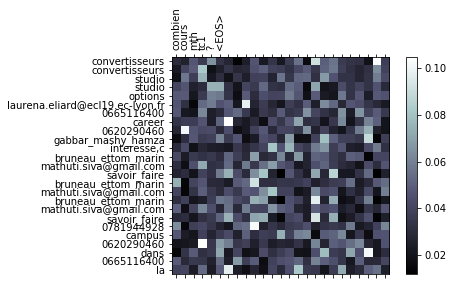

In [62]:
evaluateAndShowAttention(TrimWordsSentence(s1),encoder1,attn_decoder1,input_lang,output_lang,)

Si on regarde les poids d'attention, on peut constater que cours est important pour générer '18h'.

#### 2. problème point d'interrogation

In [80]:
q1 = "combien de cours mth tc2?"
q2 = "combien de cours mth tc2 ?"
chat(encoder1,attn_decoder1,input_lang,output_lang,q1)
chat(encoder1,attn_decoder1,input_lang,output_lang,q2)

question : combien de cours mth tc2?

bot :  ne comprend pas

question : combien de cours mth tc2 ?

bot :  12h



Q1 et Q2 sont la même question, Mais le résultat est vraiment différent, parce que 'tc2?' est considéré comme un token qui n'existe pas dans notre dictionnaire. Il correspond aux "NULL".

In [59]:
def Norm(ques):
    if ques[-1] =="?":
        ques = ques[0:-1]+" ?"
    return ques

In [82]:
Norm(q1)

'combien de cours mth tc2 ?'

In [69]:
def chat(encoder,decoder,input_lang,output_lang,sentence,stem=False):
    sentence = Norm(sentence)
    answer = ''
    for i in evaluate(encoder,decoder,input_lang,output_lang,sentence,stem=stem)[0] :
        if i == "<EOS>":
            break
        answer = answer + ' ' + i
    print("question : {}".format(sentence))
    print("bot : {}\n".format(answer))

#### 3. Stemming

L'intérêt d'utiliser le stemming :

- Diminuer la taille de dictionnaire, donc la complexité de calcul.
- Compenser le problème du grammaire.

Ici, pour les réponse on utilise le stemming. Mais pas pour les réponses, Parce qu'on veut les réponse sont normale.

In [27]:
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()
stemmer.stem('animaux')


'animal'

In [28]:
def stemString(s,stemmer):
    
    new_str = ""
    for i in s.split(' '):
        new_str = new_str + " " + stemmer.stem(i)
  
    return new_str

In [29]:
a = stemString("animaux sauvages",stemmer)
print(a)
a = normalizeString(a)
print(a)


 animal sauvag
animal sauvag


In [30]:
input_lang_stem, output_lang_stem, pairs_stem = prepareData('questions', 'answers', False,stem=True)

Reading lines...
Read 5554 sentence pairs
quel action format contient u mathemat ? (7) -> ue mathematiques contient actions formation mth tc 1 : analyse appliquee, mth tc 2 : analyse numerique, mth tc 3 : probabilites statistique, mth tc 4 : mathematiques adaptees i algebr (31)
quel action format contient u informat ? (7) -> ue informatique contient actions formation inf tc1 : algorithmique et structures donnees : conception, analyse et implementation, inf tc2 : conception et programmation objet, et inf tc3 (27)
quel action format contient u energ electr et command system ? (11) -> ue energie electrique et commande systemes contient actions formation ecs tc 0 : autonomie, ecs tc 1 : cours energie electrique, ecs tc 2 : cours d‘automatique procedes line (29)
quel action format contient u scienc et techniqu inform ? (10) -> ue sciences et techniques information contient actions formation sti tc 0 : autonomie sti, sti tc 1 : systemes electroniques, sti tc 2 : traitement signal, et sti tc 

que voit dan mati mth tc 2 : analys numer ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend dan mati mth tc 2 : analys numer ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
fait quoi mth tc 2 : analys numer ? (9) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend mth tc 2 : analys numer ? (9) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
que voit dan afmth tc 2 : analys numer ? (10) -> description af mth tc 2 : analyse numerique est : cette af pour but donner ape

qu apprend dan mati mth tc 2 : analys numer ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
fait quoi mth tc 2 : analys numer ? (9) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend mth tc 2 : analys numer ? (9) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
que voit dan afmth tc 2 : analys numer ? (10) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend dan u mth tc 2 : analys numer ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner aper

fait quoi mth tc 4 : mathemat adapte i algebre analys ? (12) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend mth tc 4 : mathemat adapte i algebre analys ? (12) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
que voit dan afmth tc 4 : mathemat adapte i algebre analys ? (13) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend dan u mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
apprend quoi dan cour mth tc 4 : mathem

quel est descript cour mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
que voit dan mati mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend dan mati mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
fait quoi mth tc 4 : mathemat adapte i algebre analys ? (12) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend mth tc 4 :

qu apprend dan u mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
apprend quoi dan cour mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend dan cour mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
quel est descript cour mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
que voit d

que voit dan afinf tc3 : projet appliqu web ? (10) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dan u inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
apprend quoi dan cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dan cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
quel est descript cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet 

que voit dan afinf tc3 : projet appliqu web ? (10) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dan u inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
apprend quoi dan cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dan cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
quel est descript cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet 

que voit dan afec tc 2 : cour d‘automat procede lineair ? (12) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dan u ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
apprend quoi dan cour ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dan cour ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
quel est descript cour ec tc 2 : cour d‘automat procede lineair ? (13)

qu apprend ec tc 2 : cour d‘automat procede lineair ? (11) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
que voit dan afec tc 2 : cour d‘automat procede lineair ? (12) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dan u ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
apprend quoi dan cour ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dan cour ec tc 2 : cour d‘automat procede lineair ? (13) -> descript

fait quoi traval pratiqu scienc et gen material et surfac ? (11) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend traval pratiqu scienc et gen material et surfac ? (11) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
que voit dan aftraval pratiqu scienc et gen material et surfac ? (12) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dan u traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
apprend quoi dan cour traval pr

quel est descript cour traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
que voit dan mati traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dan mati traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
fait quoi traval pratiqu scienc et gen material et surfac ? (11) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend tr

qu apprend dan u traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
apprend quoi dan cour traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dan cour traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
quel est descript cour traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu

que voit dan aftravaill aujourd hui ? (7) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dan u travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
apprend quoi dan cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dan cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
quel est descript cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : c

que voit dan aftravaill aujourd hui ? (7) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dan u travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
apprend quoi dan cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dan cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
quel est descript cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : c

In [31]:
for i in range(10):
    pair = pairs_stem[i]
    print(pair)

['qui est trez vp compt bar ?', 'daval_tsuna_emile est trez vp compta bar']
['quel est numero telephon trez vp compt bar ?', 'numero telephone trez vp compta bar est 0619976495']
['quel est adress mail trez vp compt bar ?', 'adresse mail trez vp compta bar est emile.daval@ecl19.ec lyon.fr']
['qui est trez vp foi bar ?', 'roszak_axo_mathieu est trez vp foyer bar']
['quel est numero telephon trez vp foi bar ?', 'numero telephone trez vp foyer bar est 0787824054']
['quel est adress mail trez vp foi bar ?', 'adresse mail trez vp foyer bar est mathieu.roszak@laposte.net']
['qui est vp hh bar ?', 'berre_eren_antonin est vp hh bar']
['quel est numero telephon vp hh bar ?', 'numero telephone vp hh bar est 0652317273']
['quel est adress mail vp hh bar ?', 'adresse mail vp hh bar est antonin.le berre@ecl19.ec lyon.fr']
['qui est vp hh bar ?', 'masfrand_luchot_aldric est vp hh bar']


On peut constater que les questions sont changées. Par contre les réponse reste le même. C'est juste ce que on souhaite et puis, on va utiliser les nouvelles dict pour former un noveau modèle.

In [32]:
new_sentence = "je ne comprend pas"
output_lang_stem.addSentence(new_sentence)
new_sentence = stemString(new_sentence,stemmer)
new_sentence = normalizeString(new_sentence)
#new_sentence = stemString(new_sentence)
new_sentence = TrimWordsSentence(new_sentence)
print(new_sentence)
input_lang_stem.addSentence(new_sentence)

ne comprend pas


In [33]:

hidden_size = 256
encoder_stem = EncoderRNN(input_lang_stem.n_words, hidden_size,n_layers=1)
decoder_stem = AttnDecoderRNN(hidden_size, output_lang_stem.n_words,n_layers=1, dropout_p=0.1)


#trainIters(encoder_stem, decoder_stem,input_lang_stem,output_lang_stem,pairs_stem,20100,save_name="stem", print_every=200,learning_rate=0.01)

In [36]:
encoder_stem.load_state_dict(torch.load(ENCODER_FILE2))
decoder_stem.load_state_dict(torch.load(DECODER_FILE2))

<All keys matched successfully>

In [77]:
q1 = "il combien de cours du mth tc1 ?"
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q1,stem=True)

q2 = "qui est le responsable du  mathematique ?"
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q2,stem=True)

q3 = "qui est le responsable de l'informatique ?"
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q3,stem=True)

q4 = "il y a combien de td du cours mth tc2 ?"
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q4,stem=True)

q5 = "Comment evalue le cours analyse numerique ?"
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q5,stem=True)

q6 = " qui est le vp du club danse?"
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q6,stem=True)

question_normalized : combien cour mth tc1 ?
question : il combien de cours du mth tc1  ?
bot :  18h

question_normalized : qui est respons mathemat ?
question : qui est le responsable du  mathematique  ?
bot :  responsable ue mathematiques est celine helbert .

question_normalized : qui est respons informat ?
question : qui est le responsable de l'informatique  ?
bot :  responsable ue informatique est dellandrea emmanuel .

question_normalized : combien td cour mth tc2 ?
question : il y a combien de td du cours mth tc2  ?
bot :  14h

question_normalized : comment evalu cour analys numer ?
question : Comment evalue le cours analyse numerique  ?
bot :  micro_test examen_terminal

question_normalized : qui est vp club dans ?
question :  qui est le vp du club danse ?
bot :  pianet__victor est vp clubs danse



In [148]:
q1 = "quel est numero de telephone manager etudes j.e. ?"
q2 = "numero de telephone manager etudes j.e. ?"
q3 = "quel est manager etudes j.e."
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q1,stem=True)
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q2,stem=True)
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q3,stem=True)

question_normalized : quel est numero telephon manag etud j.e. ?
question : quel est numero de telephone manager etudes j.e.  ?
bot :  numero telephone manager etudes j.e. est 0659154311

question_normalized : numero telephon manag etud j.e. ?
question : numero de telephone manager etudes j.e.  ?
bot :  buisson_leemouh_hippolyte est manager etudes j.e.

question_normalized : quel est manag etud j.e.
question : quel est manager etudes j.e.
bot :  millet_skohtt_alexandre est manager etudes j.e.



In [184]:
q1 = "c'est quoi adresse email trez finance ?"
q2 = "qui est adresse email trez finance ?"
q3 = "quel est adresse email trez finance ?"

chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q1,stem=True)
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q2,stem=True)
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q3,stem=True)


question_normalized : est quoi adress email trez financ ?
question : c'est quoi adresse email trez finance  ?
bot :  adresse mail trez finance est ryan.houcine@ecl19.ec lyon.fr

question_normalized : qui est adress email trez financ ?
question : qui est adresse email trez finance  ?
bot :  adresse mail trez finance est ryan.houcine@ecl19.ec lyon.fr

question_normalized : quel est adress email trez financ ?
question : quel est adresse email trez finance  ?
bot :  adresse mail trez finance est ryan.houcine@ecl19.ec lyon.fr



In [151]:
evaluateRandomly(encoder_stem, decoder_stem,input_lang_stem,output_lang_stem,stem=True)

> fait quoi maquettage numerique ?
= description af maquettage numerique est : cette action formation pour ambition permettre aux eleves ingenieurs apprehender differents aspects maquettage numerique mode
question_normalized : fait quoi maquettag numer ?
< description af maquettage numerique est : cette action formation pour ambition permettre aux eleves ingenieurs apprehender differents aspects maquettage numerique mode <EOS>

> master forme quels metiers ?
= metier data scientist
question_normalized : mast form quel meti ?
< metier data scientist <EOS>

> quel est descriptif cours ecs tc 0 : autonomie ?
= description af ecs tc 0 : autonomie est : acquerir connaissances complementaires aux cours energie electrique et d‘automatique procedes lineaires par travail autonomie
question_normalized : quel est descript cour ec tc 0 : autonom ?
< description af ecs tc 0 : autonomie est : acquerir connaissances complementaires aux cours energie electrique et d‘automatique procedes lineaires par 

#### 4. BeamSearch
Algorithem :

- 1. At the first decode step, consider the top k candidates.
- 2. Generate k second words for each of these k first words.
- 3. Choose the top k [first word, second word] combinations considering additive scores.
- 4. For each of these k second words, choose k third words, choose the top k [first word, second word, third word] combinations.
- 5. Repeat at each decode step.
- 6. After k sequences terminate, choose the sequence with the best overall score.

In [45]:
import copy
def beam_search(encoder,decoder,input_lang,output_lang,sentence,beam_size,max_length = MAX_LENGTH,stem=False):
    sentence = unicodeToAscii(sentence)
    if stem:
        sentence=stemString(sentence,stemmer)
    sentence = normalizeString(sentence)
    sentence = TrimWordsSentence(sentence)
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    decoder_output, decoder_hidden, decoder_attention = decoder(
        decoder_input, decoder_hidden, encoder_outputs)

    topv,topi = decoder_output.data.topk(beam_size)

    new_decoder_hidden = decoder_hidden.expand(beam_size,*decoder_hidden.size())

    prevs_words = torch.zeros(beam_size*beam_size,MAX_LENGTH)


    prevs_words[:,0] = SOS_token
    scores = torch.zeros(beam_size*beam_size)
    output_sentence = []
    out_scores = []
    step = 1
    for i in range(beam_size):
        scores[i*beam_size:(i+1)*beam_size] = topv[0][i]
        prevs_words[i*beam_size:(i+1)*beam_size,1] = topi[0][i].item()
        
    while(len(out_scores)<beam_size and step<20):
        for i in range (beam_size):
            decoder_input = Variable(torch.LongTensor([[prevs_words[i*beam_size,step]]]))
            decoder_hidden = new_decoder_hidden[i]
            decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
            topv,topi = decoder_output.data.topk(beam_size)
            new_decoder_hidden[i] = decoder_hidden
            for j in range(beam_size):
                prevs_words[j+i*beam_size,step+1] = topi[0][j].item()

                scores[j+i*beam_size] +=topv[0][j]



        s_topv,s_topi = scores.topk(beam_size)    
       # print(scores)
        #print(s_topi)
        prevs_words_copy = copy.deepcopy(prevs_words)
        new_decoder_hidden_copy = torch.zeros(*new_decoder_hidden.size())
        for i in range(beam_size):
            scores[i*beam_size:(i+1)*beam_size] = s_topv[i]
            prevs_words[i*beam_size:(i+1)*beam_size,:] = prevs_words_copy[s_topi[i],:]
            new_decoder_hidden_copy[i] = new_decoder_hidden[s_topi[i]//beam_size]
        new_decoder_hidden = new_decoder_hidden_copy
        for i in range(beam_size):
            if prevs_words[i*beam_size,step+1]==EOS_token and scores[i*beam_size].item()>-100:
               # print(prevs_words[i*beam_size,:],scores[i*beam_size])
                a = prevs_words[i*beam_size,:].numpy()
                b = copy.deepcopy(a)
                output_sentence.append(b)
                #print(output_sentence)
                out_scores.append(scores[i*beam_size].item())
                scores[i*beam_size:(i+1)*beam_size] = -500


        #print(step)     
        step+=1
    answer = ''
    out_sentence = output_sentence[out_scores.index(max(out_scores))]
    for i in out_sentence:
        token = output_lang.index2word[i.item()]
        if token == "EOS":
            break
        if token !="SOS":
            answer = answer + ' ' + token
   # print("question : {}\n".format(sentence))
   # print("bot : {}\n".format(answer))
    return answer
    

In [46]:
q1 = " combien de cours du mth tc1 ?"
q2 = " combien de cours du mth tc2 ?"
q3 = " combien de cours du mth tc3 ?"
q4 = " combien de cours du mth tc4 ?"
q5 = " combien de cours du mth tc5 ?"

In [ ]:
beam_search(encoder,decoder,input_lang,output_lang,sentence,beam_size,max_length = MAX_LENGTH,stem=False)

In [47]:
beam_size = 3
print("real reponse : 18")
beam_search(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q1,beam_size=3,max_length = MAX_LENGTH,stem=True)
chat(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,q1,stem=True)

real reponse : 18


TypeError: zeros() received an invalid combination of arguments - got (bool, int), but expected one of:
 * (tuple of ints size, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [237]:
def New_evaluateRandomly(encoder, decoder,input_lang,output_lang, n=10,stem=False):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        output_words, attentions = evaluate(encoder, decoder,input_lang,output_lang, pair[0],stem=stem)
        answer_stem = beam_search(encoder,decoder,input_lang,output_lang,pair[0],beam_size=3,max_length = MAX_LENGTH,stem=stem)
    
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('beam_size=3 <',answer_stem)
        print('')
        
        

In [238]:
New_evaluateRandomly(encoder_stem,decoder_stem,input_lang_stem,output_lang_stem,stem=True)

> quel est adresse e-mail trez ctn centrale television network ?
= adresse e-mail trez ctn centrale television network est fabrice.moeneclaey@ecl19.ec-lyon.fr
norm_question : quel etre adresse e-mail trez ctn centrale television network ?
< adresse e-mail trez ctn centrale television network est 0780357190 <EOS>
beam_size=3 <  adresse e-mail trez centrale television network est 0780357190

> qui est sg cchecl club changement heure ecl ?
= parinello_noss_guillaume est sg cchecl club changement heure ecl
norm_question : qui etre sg cchecl club changement heure ecl ?
< parinello_noss_guillaume est sg cchecl club changement heure ecl <EOS>
beam_size=3 <  parinello_noss_guillaume est cchecl club changement heure ecl

> quel est adresse e-mail vp projet bar ?
= adresse e-mail vp projet bar est gaia.vialette@orange.fr
norm_question : quel etre adresse e-mail vp projet bar ?
< adresse e-mail vp projet bar est 0635146009 <EOS>
beam_size=3 <  adresse e-mail bar est 0635146009

> quel est adresse

Principalement, ils ont le même résultat.

#### 5. Negative sampling
- Use "negative sampling", i.e. sampling random words to form incorrect questions (answering the question with something like 'I don't understand your question, sorry.' in order to enforce the model recognize a questions that are not syntactically (and semantically) correct. 
The probability for selecting a word as a negative sample should be related to its frequency, with more frequent words being more likely to be selected as negative samples. 

In [32]:
## Here we create a sentence randomly.
## We need a dictionaire to find the frequence of a word 
## We can define the length of the sentence we need
## We use the ratio between the occurrence of a word and the total occurrence as the threshold
## Then we use the 0-1 distribution model. If the ratio behind 0.01, we use 0.01 as threshold.
def create_sentence(dict_w2c,sentence_length):
    length_word = len(dict_w2c)
    nom_tot = sum(list(dict_w2c.values()))
    words = list(dict_w2c.keys())
    values = list(dict_w2c.values())
    output_sentence = []

    while(len(output_sentence)<sentence_length-1):
        #print(output_sentence)
        i2d = random.randint(0,length_word-1)
        val = values[i2d]
        if (val/nom_tot<0.01):
            if(random.random()<0.01) and words[i2d]!="?":
                output_sentence.append(words[i2d])
        else:
            if (random.random()< val/nom_tot) and words[i2d]!="?":
                output_sentence.append(words[i2d])
    sentence = ' '.join(output_sentence)
    sentence+=' ?'
    return sentence
        

In [33]:
create_sentence(input_lang_stem.word2count,4)

'graph lois langu ?'

In [34]:
input_lang_stem, output_lang_stem, pairs_stem = prepareData('questions', 'answers', False,stem=True)

Reading lines...
Read 5554 sentence pairs
quel action format contient u mathemat ? (7) -> ue mathematiques contient actions formation mth tc 1 : analyse appliquee, mth tc 2 : analyse numerique, mth tc 3 : probabilites statistique, mth tc 4 : mathematiques adaptees i algebr (31)
quel action format contient u informat ? (7) -> ue informatique contient actions formation inf tc1 : algorithmique et structures donnees : conception, analyse et implementation, inf tc2 : conception et programmation objet, et inf tc3 (27)
quel action format contient u energ electr et command system ? (11) -> ue energie electrique et commande systemes contient actions formation ecs tc 0 : autonomie, ecs tc 1 : cours energie electrique, ecs tc 2 : cours d‘automatique procedes line (29)
quel action format contient u scienc et techniqu inform ? (10) -> ue sciences et techniques information contient actions formation sti tc 0 : autonomie sti, sti tc 1 : systemes electroniques, sti tc 2 : traitement signal, et sti tc 

qu apprend dan mati mth tc 2 : analys numer ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
fait quoi mth tc 2 : analys numer ? (9) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend mth tc 2 : analys numer ? (9) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
que voit dan afmth tc 2 : analys numer ? (10) -> description af mth tc 2 : analyse numerique est : cette af pour but donner apercu methodes numeriques utiles ingenieur dans differents contextes. techniques decrite (25)
qu apprend dan u mth tc 2 : analys numer ? (11) -> description af mth tc 2 : analyse numerique est : cette af pour but donner aper

quel est descript cour mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
que voit dan mati mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend dan mati mth tc 4 : mathemat adapte i algebre analys ? (14) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
fait quoi mth tc 4 : mathemat adapte i algebre analys ? (12) -> description af mth tc 4 : mathematiques adaptees i algebre analyse est : dans cette af sont presentes outils base algebre et analyse mathematique : espaces vectoriels, (27)
qu apprend mth tc 4 :

que voit dan afinf tc3 : projet appliqu web ? (10) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dan u inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
apprend quoi dan cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
qu apprend dan cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet application web est : objectif cette action formation est mettre pratique notions et competences introduites par autres af dans cad (26)
quel est descript cour inf tc3 : projet appliqu web ? (11) -> description af inf tc3 : projet 

que voit dan afec tc 2 : cour d‘automat procede lineair ? (12) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dan u ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
apprend quoi dan cour ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
qu apprend dan cour ec tc 2 : cour d‘automat procede lineair ? (13) -> description af ecs tc 2 : cours d‘automatique procedes lineaires est : objectif cours est degager points communs tout probleme automatique lineaire : choix i (25)
quel est descript cour ec tc 2 : cour d‘automat procede lineair ? (13)

fait quoi traval pratiqu scienc et gen material et surfac ? (11) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend traval pratiqu scienc et gen material et surfac ? (11) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
que voit dan aftraval pratiqu scienc et gen material et surfac ? (12) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dan u traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
apprend quoi dan cour traval pr

qu apprend dan u traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
apprend quoi dan cour traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu apprend dan cour traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
quel est descript cour traval pratiqu scienc et gen material et surfac ? (13) -> description af travaux pratiques science et genie materiaux et surfaces est : faire connaitre et pratiquer essais plus utilises pour acceder aux proprietes et compor (25)
qu

que voit dan aftravaill aujourd hui ? (7) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dan u travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
apprend quoi dan cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
qu apprend dan cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : cours compte 7 cm et 2 td. interroge place qu occupe travail dans nos societes occidentales et porte regard principalement soci (28)
quel est descript cour travaill aujourd hui ? (8) -> description af travailler aujourd hui est : c

In [35]:
create_sentence(input_lang.word2count,4)
def create_pair(input_sentence):
    pair = [input_sentence,"je ne comprend pas"]
    return pair

def add_newpair(pairs,word2count,nomb=100,length_sent=7):
    for i in range(nomb):
        input_sentence = create_sentence(word2count,length_sent)
        pair = create_pair(input_sentence)
        pairs.append(pair)
    return pairs

In [36]:
new_sentence = "je ne comprend pas"
output_lang_stem.addSentence(new_sentence)
new_sentence = stemString(new_sentence,stemmer)
new_sentence = normalizeString(new_sentence)
#new_sentence = stemString(new_sentence)
new_sentence = TrimWordsSentence(new_sentence)
print(new_sentence)
input_lang_stem.addSentence(new_sentence)

ne comprend pas


In [37]:
## We add 30 sentences to the pairs
print(len(pairs))
print(pairs[-1])
number = 30
paris = add_newpair(pairs,input_lang.word2count,nomb=number)
print(len(pairs))
print(pairs[-1])

5040
['qu apprend dans matiere ethique ?', 'description af ethique est : cours traite enjeux ethiques lies aux metiers ingenieurs, et, plus largement, aux sciences et technologies contemporaines. ethique caracterise dim']
5070
['statistique modules tant fiction centrale applique ?', 'je ne comprend pas']


In [38]:
hidden_size = 256
encoder_stem = EncoderRNN(input_lang_stem.n_words, hidden_size,n_layers=1)
decoder_stem = AttnDecoderRNN(hidden_size, output_lang_stem.n_words,n_layers=1, dropout_p=0.1)


trainIters(encoder_stem, decoder_stem,input_lang_stem,output_lang_stem,pairs_stem,100000,save_name="stem_ns", print_every=200,learning_rate=0.01)

0m 45s (- 376m 36s) (200 0%) 5.3524
1m 20s (- 334m 4s) (400 0%) 4.7210
1m 56s (- 322m 42s) (600 0%) 4.6634
2m 30s (- 311m 21s) (800 0%) 4.1979
3m 5s (- 306m 28s) (1000 1%) 4.0658
3m 44s (- 308m 35s) (1200 1%) 3.8010
4m 24s (- 310m 22s) (1400 1%) 3.6545
5m 6s (- 314m 36s) (1600 1%) 3.4091
5m 53s (- 321m 10s) (1800 1%) 3.1485
6m 41s (- 328m 7s) (2000 2%) 2.8284
7m 27s (- 331m 42s) (2200 2%) 2.5726
8m 12s (- 334m 2s) (2400 2%) 2.3113
8m 59s (- 337m 4s) (2600 2%) 2.1350
9m 40s (- 335m 47s) (2800 2%) 2.1757
10m 24s (- 336m 19s) (3000 3%) 1.8355


KeyboardInterrupt: 